#refer  for understanding below packages : https://www.kaggle.com/code/ravi20076/janestreet2024-baseline-submission-v1/notebook#for lstm refer : https://www.kaggle.com/code/tarriaza/basic-pytorch-lstm

In [1]:
#!pip install polars[gpu]==1.9.0 -q --no-index --find-links=/kaggle/input/janestreet2024-imports-v1/polars!pip install lightgbm==4.5.0 -q --no-index --find-links=/kaggle/input/janestreet2024-imports-v1/packages!pip install scikit-learn==1.5.2 -q --no-index --find-links=/kaggle/input/janestreet2024-imports-v1/packages

In [2]:
#!pip install xgboost==2.1.1 -q --no-index --find-links=/kaggle/input/janestreet2024-imports-v1/packages

In [3]:
exec(open("/kaggle/input/janestreet2024-imports-v1/myimports.py", "r").read())

---> Imports- part 1 done

---> Commencing imports-part2
---> XGBoost = 2.0.3 | LightGBM = 4.2.0
---> Imports- part 2 done
---> Imports done


refer :https://www.kaggle.com/code/abdullah0a/jane-street-financial-market-responders-upvotefor understanding how other people do prediction 

In [ ]:
from tqdm import tqdm
import polars as pl
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

In [4]:
def impute_with_formula_and_fallback(df: pl.DataFrame, alpha=1.0, beta=1.0, gamma=1.0, delta=1.0, epsilon=1e-5):
    # Create a mutable copy of the DataFrame
    imputed_df = df.clone()

    for column in df.columns:
        X = df[column]

        # Calculate statistics and handle columns with only nulls
        mean_X = X.mean()
        max_X = X.max()
        min_X = X.min()
        std_X = X.std()

        if mean_X is None or max_X is None or min_X is None or std_X is None:
            # If the entire column is null, fill it with 0
            imputed_df = imputed_df.with_columns(pl.col(column).fill_null(0).alias(column))
            continue

        # Adjust max_X and min_X to avoid division by zero
        if max_X == min_X:
            max_X += epsilon  
            min_X -= epsilon  

        if std_X == 0:
            std_X += epsilon

        # Collect values and apply imputation
        imputed_values = []
        for i in range(len(X)):
            value = X[i]
            if value is None:  # Check for missing values
                try:
                    X_imputed = (alpha * mean_X + 
                                 beta * (max_X - value) / (max_X - min_X) +
                                 gamma * np.log((max_X - value) / min_X) +
                                 delta * (std_X / (max_X - min_X)))
                    imputed_values.append(X_imputed)
                except:
                    imputed_values.append(mean_X)
            else:
                imputed_values.append(value)

        # Assign the imputed values back to the column in the DataFrame
        imputed_df = imputed_df.with_columns(pl.Series(imputed_values).alias(column))

    # Fallback for any remaining missing values
    if imputed_df.null_count().select(pl.all().sum()).row(0)[0] > 0:
        print("Some values were still NaN after initial imputation. Filling with 0 as fallback.")
        imputed_df = imputed_df.fill_null(0)

    return imputed_df


In [ ]:


# Load data
test_data = pl.scan_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=0/part-0.parquet')

# Get column names without triggering computation
column_names = test_data.collect_schema().names()
print("Columns in dataset:", column_names)  # Debugging step to check column names

# Assuming `responder_6` and `weight` exist, extract labels
y_test = test_data.select('responder_6').collect().to_numpy().reshape(-1)
y_test_weights = test_data.select('weight').collect().to_numpy().reshape(-1)

# Remove all columns that contain "responder" in the name
columns_to_keep = [col for col in column_names if "responder" not in col]

test = (
    test_data
    .select(columns_to_keep)  # Select columns excluding those containing "responder"
    .collect()  # Collect the data eagerly after selection
)

# Check the column names after selection
print("Columns after exclusion:", test.columns)

# Impute missing values using the provided formula
test_features_imputed = impute_with_formula_and_fallback(test, alpha=0.5, beta=1.0, gamma=1.5, delta=0.7)
test_features_imputed = test_features_imputed.fill_null(0)

# Optional: Check for remaining null values
null_counts = test_features_imputed.null_count()
print("Null counts after imputation:", null_counts)


Columns in dataset: ['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_6

In [6]:
print(y_test.shape)
print(test_features_imputed.shape)

(1944210,)
(1944210, 83)


In [7]:
from tqdm import tqdm
import polars as pl
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd

# Load data
train_data = pl.scan_parquet('/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id=9/part-0.parquet')

# Get column names without triggering computation
column_names = train_data.collect_schema().names()
print("Columns in dataset:", column_names)  # Debugging step to check column names

# Assuming `responder_6` and `weight` exist, extract labels
y_train = train_data.select('responder_6').collect().to_numpy().reshape(-1)
y_train_weights = train_data.select('weight').collect().to_numpy().reshape(-1)

# Remove all columns that contain "responder" in the name
columns_to_keep = [col for col in column_names if "responder" not in col]

train = (
    train_data
    .select(columns_to_keep)  # Select columns excluding those containing "responder"
    .collect()  # Collect the data eagerly after selection
)

# Check the column names after selection
print("Columns after exclusion:", test.columns)

# Impute missing values using the provided formula
train_features_imputed = impute_with_formula_and_fallback(train, alpha=0.5, beta=1.0, gamma=1.5, delta=0.7)
train_features_imputed = train_features_imputed.fill_null(0)

# Optional: Check for remaining null values
null_counts = train_features_imputed.null_count()
print("Null counts after imputation:", null_counts)


Columns in dataset: ['date_id', 'time_id', 'symbol_id', 'weight', 'feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_6

In [8]:
print(y_train.shape)
print(train_features_imputed.shape)

(6274576,)
(6274576, 83)


# feature importance

In [11]:
all_columns = train_features_imputed.columns

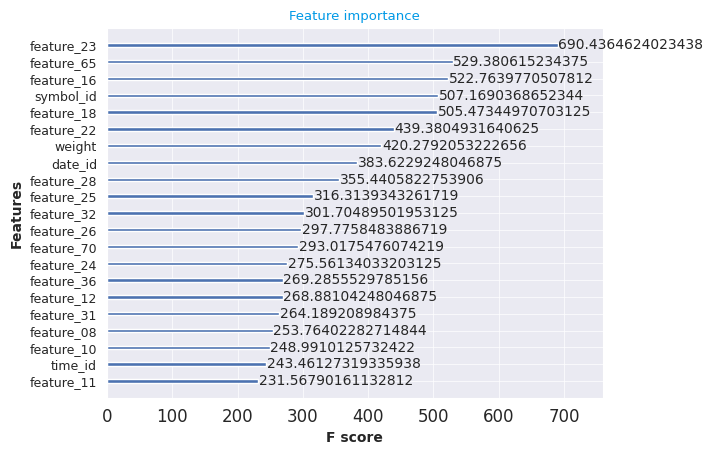

In [12]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt



# Assuming X_train, X_test, y_train, y_test are already defined
dtrain = xgb.DMatrix(train_features_imputed, label=y_train, feature_names=all_columns)
dtest = xgb.DMatrix(test_features_imputed, label=y_test, feature_names=all_columns)

# Train model
params = {
    'objective': 'reg:squarederror', 
    'max_depth': 6, 
    'learning_rate': 0.1,
    'tree_method': 'hist'
}
model = xgb.train(params, dtrain, num_boost_round=100)

# Plot feature importance
xgb.plot_importance(model, importance_type='gain', max_num_features=21)
plt.show()


# lets go 21features to understand the performance 

In [13]:
selected_features = ['feature_23','feature_65','feature_16','symbol_id','feature_18','feature_22','weight',
                     'date_id','feature_28','feature_25','feature_32','feature_26','feature_70','feature_24',
                     'feature_36','feature_12','feature_31','feature_08','feature_10','time_id','feature_11']

In [14]:
X_train= train_features_imputed[selected_features]
X_test = test_features_imputed[selected_features]

In [15]:
import xgboost as xgb
dtrain= xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_test, label=y_test)

In [104]:
params = {
    'objective': 'reg:squarederror',  # Regression task
    'max_depth': 7,  # Depth of the tree (control overfitting)
    'learning_rate': 0.001,  # Learning rate (smaller values tend to be more robust but require more boosting rounds)
    'n_estimators': 100,  # Number of boosting rounds
    'subsample': 0.8,  # Subsample ratio for training data
    'colsample_bytree': 0.7,  # Fraction of features to consider for each tree
    'lambda': 0.001,  # L2 regularization
    'alpha': 0.001,  # L1 regularization
    'tree_method': 'hist',  # Histogram-based algorithm (faster for large datasets)
    'device': 'cuda',
    'n_jobs': -1  # Use all available CPU cores
}

In [105]:
model = xgb.train(params, dtrain, num_boost_round=100)

In [106]:
def custom_metric(y_true, y_pred, weight):
    weighted_r2 = 1 - (np.sum(weight * (y_true - y_pred) ** 2) / np.sum(weight * y_true ** 2))
    return weighted_r2

In [107]:
y_pred= model.predict(dval)
score = custom_metric(y_test,y_pred,y_test_weights)
print(score)

7.832050323486328e-05


In [108]:
import joblib
joblib.dump(model, 'exp11.joblib')

['exp11.joblib']

In [ ]:
model1= joblib.load('/kaggle/working/exp11.joblib')
y_pred = model1.predict(dval)
print(score)

0.9988959528272972